### ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

#### Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

При выявлении интересных закономерностей, отметьте их в своём анализе.

#### Загрузка данных 

In [148]:
# загружаем необходимые библиотеки
import pandas as pd
#import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook")
sns.set_palette("Set2")

# загружаем датасет
data = pd.read_csv('data/ds_salaries.zip')
display(data.head())

# задаём уровень значимости
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


Уровень значимости alpha = 0.05


#### Описательный анализ данных

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


Удаляем не информативные столбцы.

In [150]:
#удаляем не информативный столбец
data = data.drop('Unnamed: 0', axis=1)
#столбец salary предоставляет сведения в разных валютах, поэтому после создания salary_in_usd, его можно удалить
data = data.drop('salary', axis=1)

В наборе данных 607 записей (без пропусков)
Проверим на наличие дубликатов записей:

In [151]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 10)


Корректируем тип данных для категорий, которые определились как числовые.

In [152]:
#столбцы work_year и remote_ratio является категориальным, поэтому меняем его тип на object
data['remote_ratio'] = data['remote_ratio'].astype('object')
data['work_year'] = data['work_year'].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    object
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_currency     565 non-null    object
 5   salary_in_usd       565 non-null    int64 
 6   employee_residence  565 non-null    object
 7   remote_ratio        565 non-null    object
 8   company_location    565 non-null    object
 9   company_size        565 non-null    object
dtypes: int64(1), object(9)
memory usage: 48.6+ KB


Все (оставшиеся) признаки классифицированы правильно:
- 9 Категориальных
- 1 Числовое

In [153]:
#Основные статистические характеристики признаков
data.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.0,565,565,565,565,565.000000,565,565.0,565,565
unique,3.0,4,4,50,17,NaN,57,3.0,50,3
top,2022.0,SE,FT,Data Scientist,USD,NaN,US,100.0,US,M
freq,278.0,243,546,130,359,NaN,295,346.0,318,290
mean,NaN,NaN,NaN,NaN,NaN,110610.343363,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,72280.702792,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,2859.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,60757.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,100000.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN,NaN


### Визуальный анализ

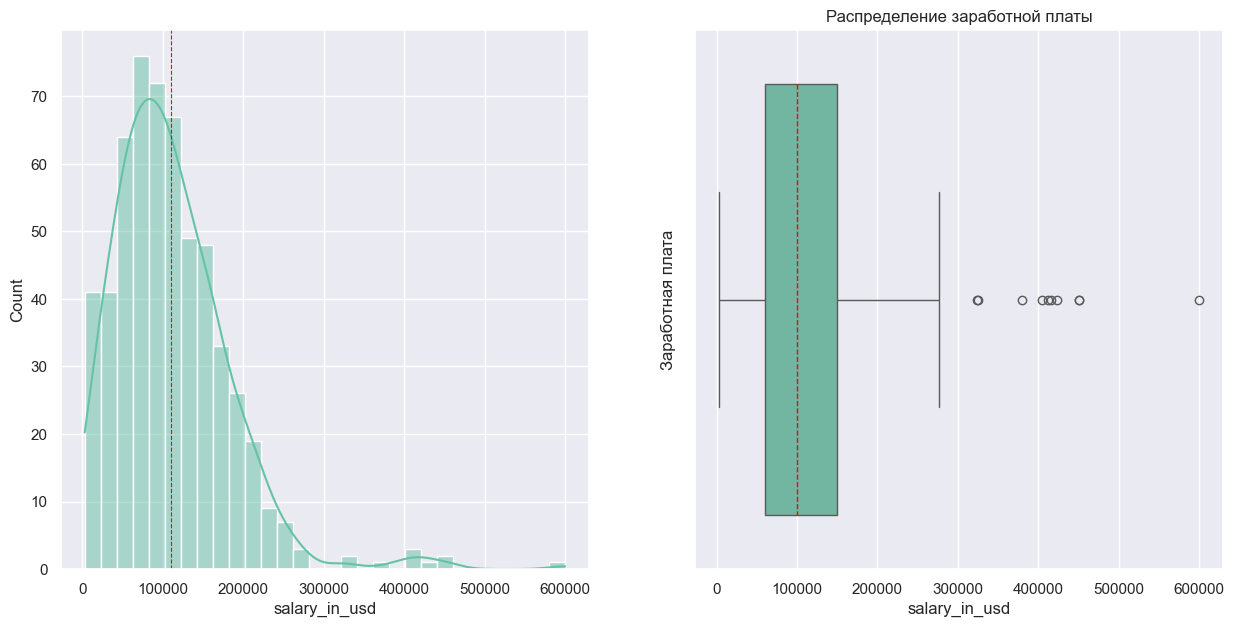

In [154]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.subplots_adjust(hspace=0.4)

sns.histplot(data['salary_in_usd'], bins=30, kde=True, ax=axes[0])

axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Заработная плата')
axes[1].set_title('Распределение заработной платы')

plt.show()

In [155]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Заработная плата']
data_agg

,Заработная плата
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Распределение заработной платы отличается от нормального, при этом отмечаются выбросы в виде редких выплат в размерах общей выплаченной валовой суммы заработной платы свыше 300 тыс. долларов.

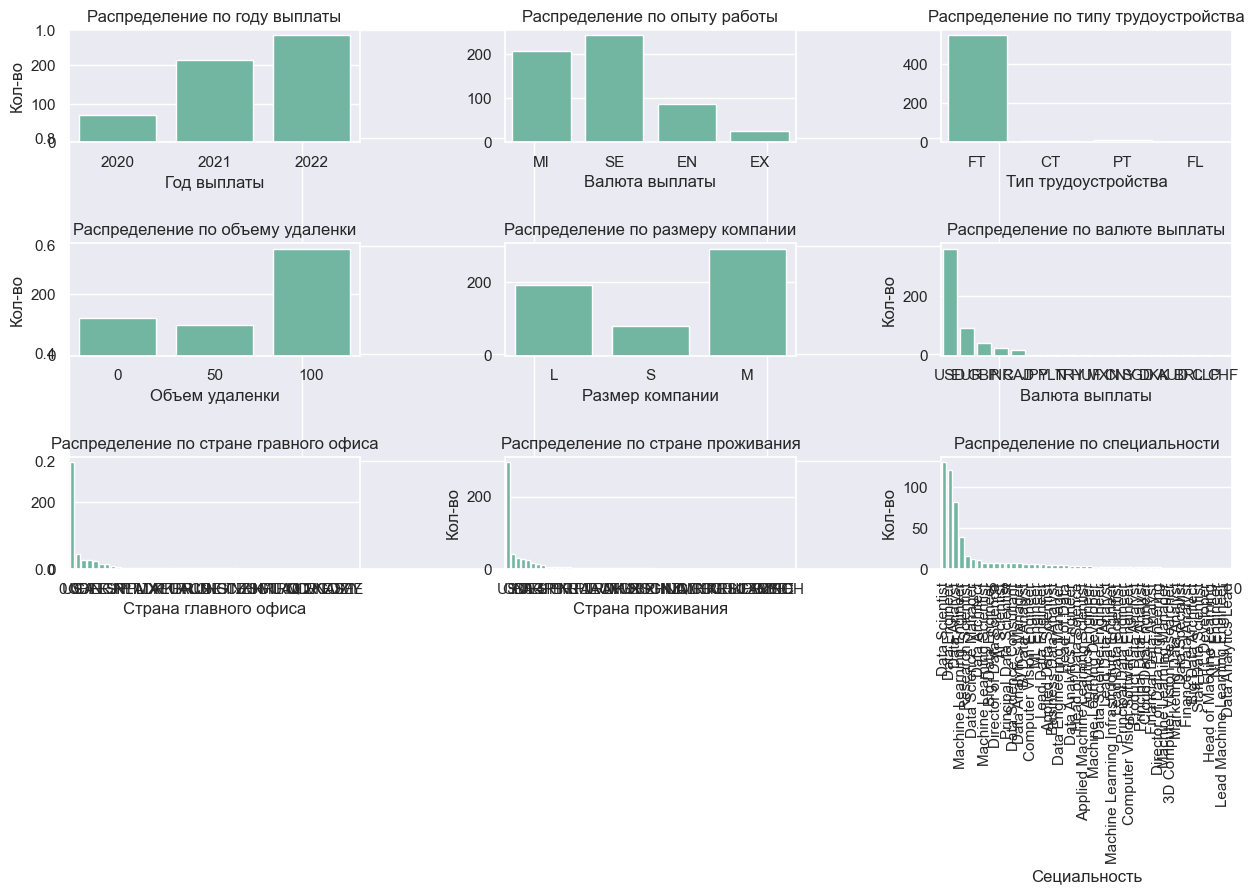

In [156]:
import matplotlib.gridspec as gridspec

x_name = 'Кол-во'

fig, axes = plt.subplots(figsize=(15,7))

gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.9, wspace=0.5)

#первая строка графиков
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

sns.countplot(data, x='work_year', ax=ax1)
ax1.set_title('Распределение по году выплаты')
ax1.set(xlabel='Год выплаты', ylabel=x_name)

sns.countplot(data, x='experience_level', ax=ax2)
ax2.set_title('Распределение по опыту работы')
ax2.set(xlabel='Валюта выплаты', ylabel='')

sns.countplot(data, x='employment_type', ax=ax3)
ax3.set_title('Распределение по типу трудоустройства')
ax3.set(xlabel='Тип трудоустройства', ylabel='')

#вторая строка
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1,2])

sns.countplot(data, x='remote_ratio', ax=ax4)
ax4.set_title('Распределение по объему удаленки')
ax4.set(xlabel='Объем удаленки', ylabel=x_name)

sns.countplot(data, x='company_size', ax=ax5)
ax5.set_title('Распределение по размеру компании')
ax5.set(xlabel='Размер компании', ylabel='')

order_currency = data['salary_currency'].value_counts().index
sns.countplot(data, x='salary_currency', order = order_currency, ax=ax6)
ax6.set_title('Распределение по валюте выплаты')
ax6.set(xlabel='Валюта выплаты', ylabel=x_name)

#третья строка
ax7 = fig.add_subplot(gs[2,0])
ax8 = fig.add_subplot(gs[2,1])
ax9 = fig.add_subplot(gs[2,2])

#сортировка по количеству
order_location = data['company_location'].value_counts().index
sns.countplot(data, x='company_location', order = order_location, ax=ax7)
ax7.set_title('Распределение по стране гравного офиса')
ax7.set(xlabel='Страна главного офиса', ylabel='')
plt.xticks(rotation=90)  # Повернуть подписи, если длинные

order_residence = data['employee_residence'].value_counts().index
sns.countplot(data, x='employee_residence', order=order_residence, ax=ax8)
ax8.set_title('Распределение по стране проживания')
ax8.set(xlabel='Страна проживания', ylabel=x_name)
plt.xticks(rotation=90)  # Повернуть подписи, если длинные

#сортировка по количеству
order_job_title = data['job_title'].value_counts().index
#формируем график
sns.countplot(data, x='job_title', order = order_job_title, ax=ax9)
ax9.set_title('Распределение по специальности')
ax9.set(xlabel='Cециальность', ylabel=x_name)
plt.xticks(rotation=90)  # Повернуть подписи, если длинные

plt.show()


In [157]:
#Функция вывода диаграммы распределения заработной платы в зависимости от заданного показателя
def show_boxplot(job_DF, category, category_name, p_axes, p_title = True):

    box = sns.boxplot(job_DF, y=category, x='salary_in_usd', ax = p_axes, orient='h', medianprops={"color": "red", "linestyle": '--'})
    box.set(xlabel='', ylabel=category_name)
    if p_title:
        box.set_title('Распределение заработной')
    else:
        box.set_title('')

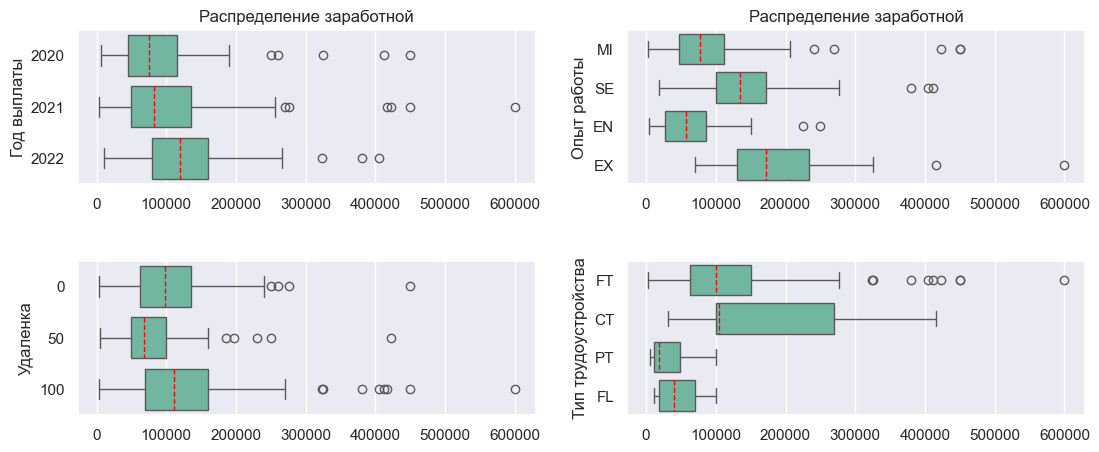

In [158]:
fig, axes = plt.subplots(2,2, figsize=(13, 5))
fig.subplots_adjust(hspace=0.5)

show_boxplot(data, 'work_year', 'Год выплаты', axes[0,0])
show_boxplot(data, 'experience_level', 'Опыт работы', axes[0,1])
show_boxplot(data, 'remote_ratio', 'Удаленка', axes[1,0], False)
show_boxplot(data, 'employment_type', 'Тип трудоустройства', axes[1,1], False)
plt.show()

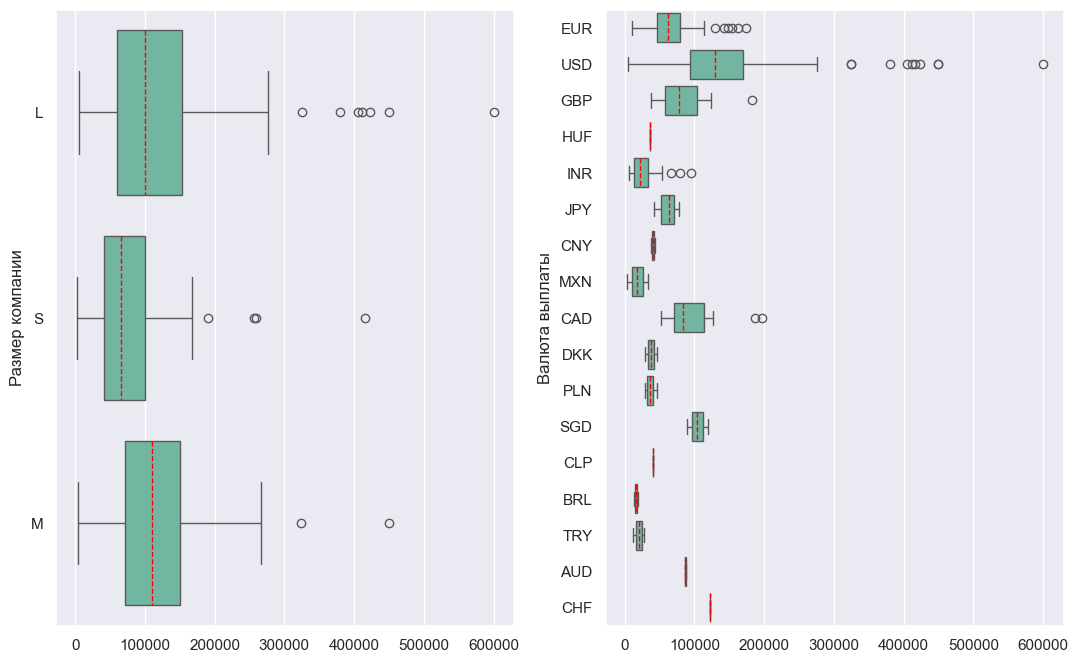

In [159]:
fig, axes = plt.subplots(1,2, figsize=(13, 8))
fig.subplots_adjust(hspace=0.5)

show_boxplot(data, 'company_size', 'Размер компании', axes[0], False)
show_boxplot(data, 'salary_currency', 'Валюта выплаты', axes[1], False)

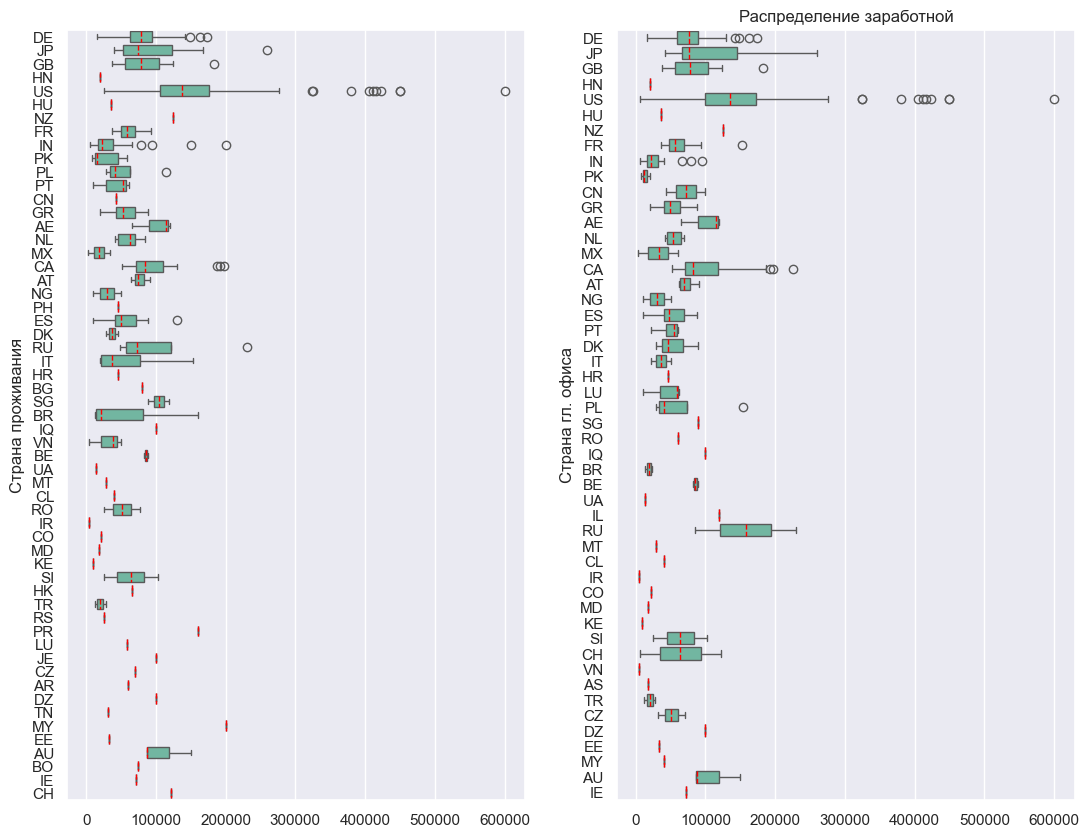

In [160]:
fig, axes = plt.subplots(1,2, figsize=(13, 10))
fig.subplots_adjust(hspace=0.5)

show_boxplot(data, 'employee_residence', 'Страна проживания', axes[0], False)
show_boxplot(data, 'company_location', 'Страна гл. офиса', axes[1])

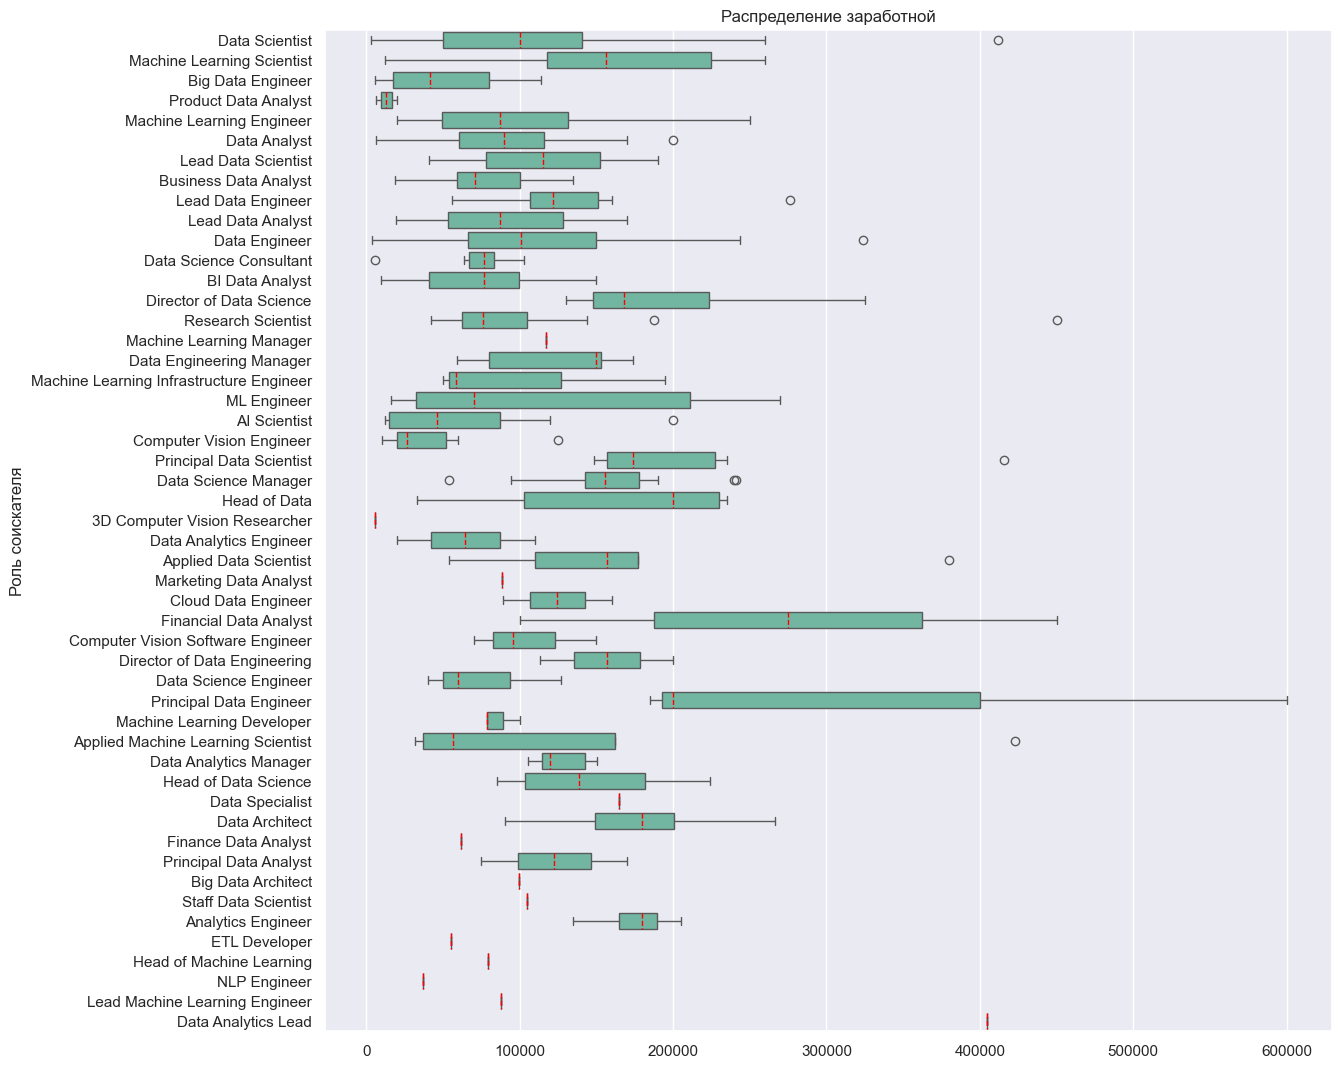

In [161]:
fig, axes = plt.subplots(figsize=(13, 13))
show_boxplot(data,'job_title', 'Роль соискателя', axes)

Общий визуальный анализ данных показывает, что все признаки, так или иначе могут влиять на размер заработной платы соискателей, по всем должностям. 

Для предварительного ответа на первый вопрос задания, проведем визуальный анализ влияния показателий на заработную плату Data Scientist.

Для этого формируем набор данных с фильтром по заданной специальности.

In [162]:
mask = data['job_title']=='Data Scientist'
data_DS = data[mask]
display(data_DS.head(3))
data_DS.info()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,EUR,79833,DE,0,DE,L
7,2020,MI,FT,Data Scientist,HUF,35735,HU,50,HU,L
10,2020,EN,FT,Data Scientist,EUR,51321,FR,0,FR,S


<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 0 to 599
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           130 non-null    object
 1   experience_level    130 non-null    object
 2   employment_type     130 non-null    object
 3   job_title           130 non-null    object
 4   salary_currency     130 non-null    object
 5   salary_in_usd       130 non-null    int64 
 6   employee_residence  130 non-null    object
 7   remote_ratio        130 non-null    object
 8   company_location    130 non-null    object
 9   company_size        130 non-null    object
dtypes: int64(1), object(9)
memory usage: 11.2+ KB


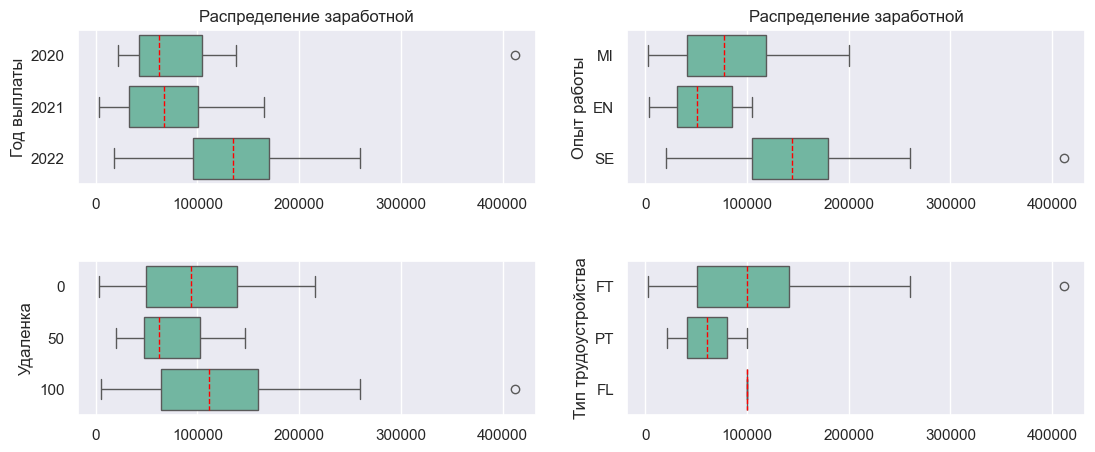

In [163]:
fig, axes = plt.subplots(2,2, figsize=(13, 5))
fig.subplots_adjust(hspace=0.5)

show_boxplot(data_DS, 'work_year', 'Год выплаты', axes[0,0])
show_boxplot(data_DS, 'experience_level', 'Опыт работы', axes[0,1])
show_boxplot(data_DS, 'remote_ratio', 'Удаленка', axes[1,0], False)
show_boxplot(data_DS, 'employment_type', 'Тип трудоустройства', axes[1,1], False)
plt.show()

In [164]:
data_DS['employment_type'].value_counts()

employment_type
FT    127
PT      2
FL      1
Name: count, dtype: int64

В 2022 году зарплата по профессии Data Sсientist, по сравнению с предшествующими двумя годами, значительно выросла. 

Что может `указывать на ежегодный рост заработной платы специалистов Data Scientist`

На заработную плату данной категории работников, влияют:
- опыт работы, 
- объем работ, проведенных удаленно

Фактор тип трудоустройства для специальности Data Scientist является не информативным, в силу того,, что из 130 значений 127 являются уникальными, поэтому далее он не будет рассматриваться

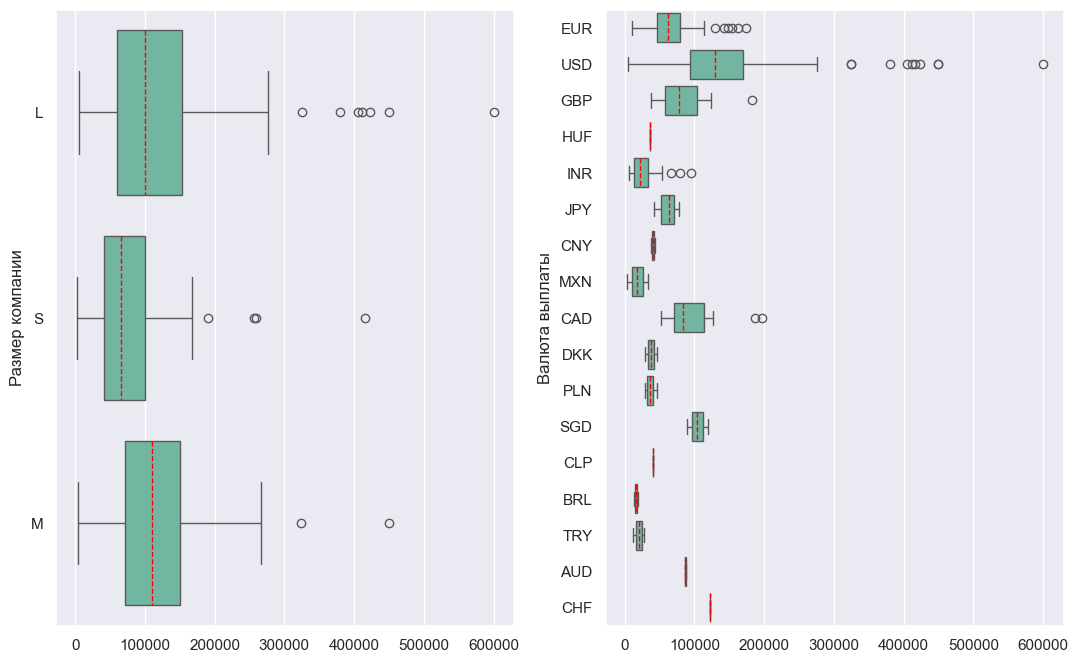

In [165]:
fig, axes = plt.subplots(1,2, figsize=(13, 8))
fig.subplots_adjust(hspace=0.5)

show_boxplot(data, 'company_size', 'Размер компании', axes[0], False)
show_boxplot(data, 'salary_currency', 'Валюта выплаты', axes[1], False)

Так же на заработную плату влияет валюта выплаты, но очевидно этот показатель имеет прямую связь со страной проживания соискателя, и может быть исключен из дальнейшего анализа. 

`Размер компании не сильно влияет` на заработную плату специалистов Data Scientist

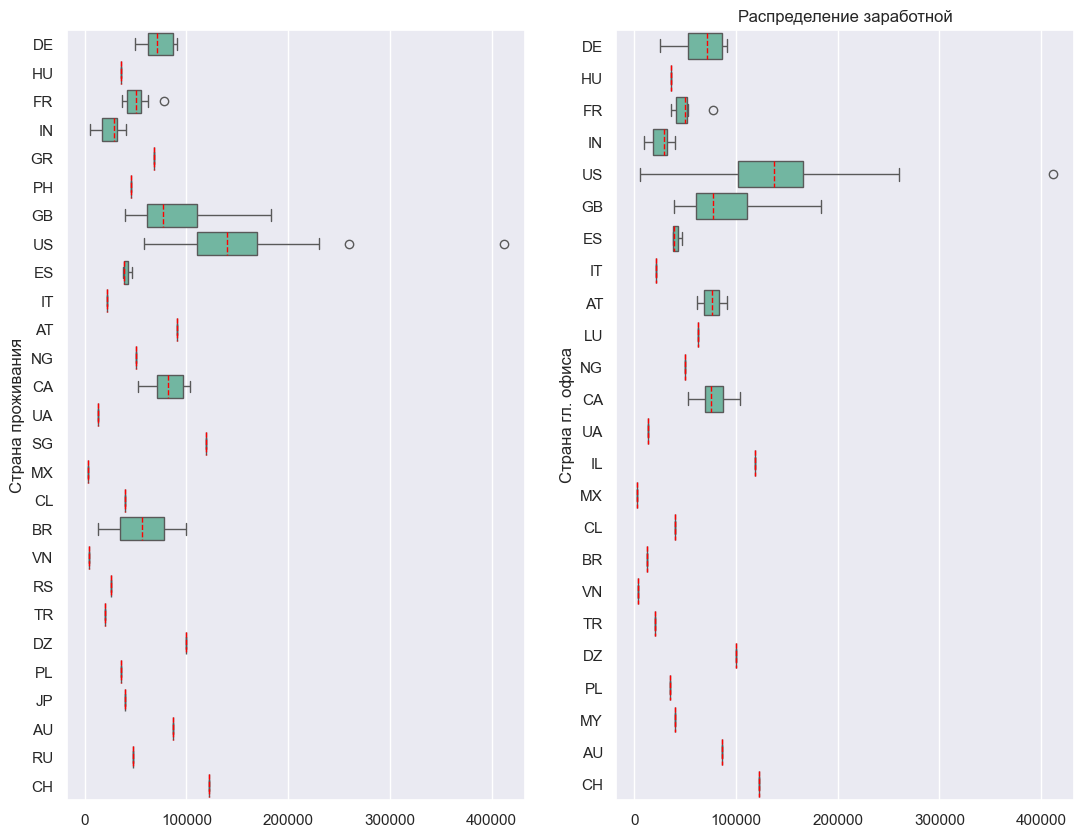

In [166]:
fig, axes = plt.subplots(1,2, figsize=(13, 10))
fig.subplots_adjust(hspace=0.5)

show_boxplot(data_DS, 'employee_residence', 'Страна проживания', axes[0], False)
show_boxplot(data_DS, 'company_location', 'Страна гл. офиса', axes[1])

Уровень зарплаты аналитиков, так же зависит от страны проживания, размещения главного офиса и вылюты используемой при выплате зарплаты.

Визуальный анализ показал что практически все визуализированные факторы `могут оказывать влияние на уровень заработной платы`

In [167]:
mask = data['job_title'].isin(['Data Scientist','Data Engineer'])
data_DS_plus = data[mask]
display(data_DS_plus.head(3))
data_DS_plus.info()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,EUR,79833,DE,0,DE,L
7,2020,MI,FT,Data Scientist,HUF,35735,HU,50,HU,L
10,2020,EN,FT,Data Scientist,EUR,51321,FR,0,FR,S


<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 0 to 603
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           251 non-null    object
 1   experience_level    251 non-null    object
 2   employment_type     251 non-null    object
 3   job_title           251 non-null    object
 4   salary_currency     251 non-null    object
 5   salary_in_usd       251 non-null    int64 
 6   employee_residence  251 non-null    object
 7   remote_ratio        251 non-null    object
 8   company_location    251 non-null    object
 9   company_size        251 non-null    object
dtypes: int64(1), object(9)
memory usage: 21.6+ KB


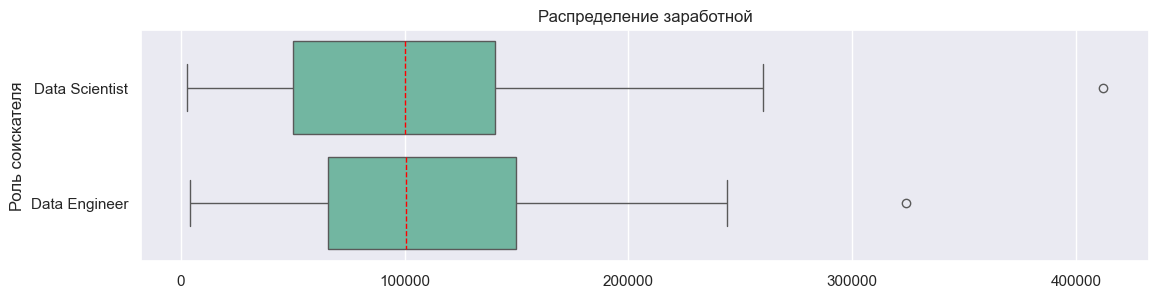

In [168]:
fig, axes = plt.subplots(figsize=(13, 3))
show_boxplot(data_DS_plus,'job_title', 'Роль соискателя', axes)

В `среднем, уровень зарплаты Data Scientist и Data Engineer находятся на одном уровне`, однако зарплата Data Scientist имееть чуть больший разброс и максимальные значения (в качестве выбросов), что указывает, на незначительный но все таки потенциал заработной платы Data Scientist больше чем Data Engineer.

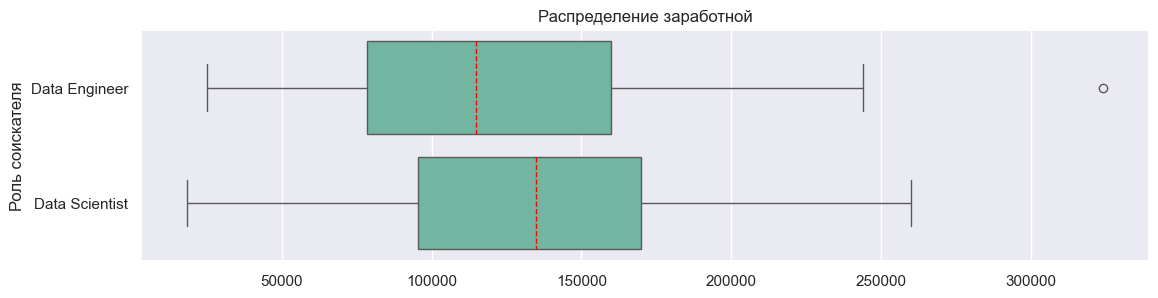

In [169]:
mask = data_DS_plus['work_year'] == 2022
fig, axes = plt.subplots(figsize=(13, 3))
show_boxplot(data_DS_plus[mask],'job_title', 'Роль соискателя', axes)

В 2022 году разность между уровнями зарплаты специалистов Data Scientist увеличилась Data Engineer и уже можно предполагать что Data Scientist является более оплачиваемой специальностью чем Data Engineer

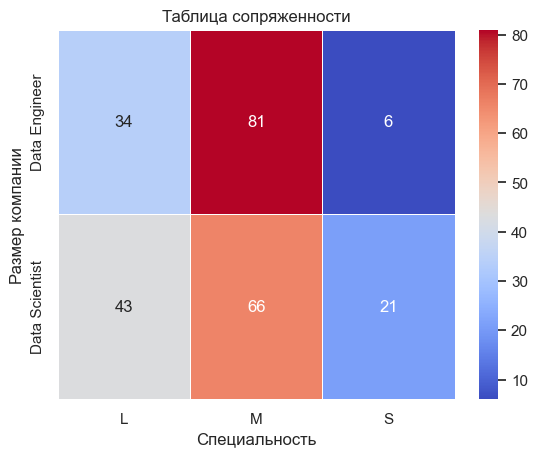

In [170]:
cross_tab = pd.crosstab(index=data_DS_plus['job_title'], columns=data_DS_plus['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Специальность', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

Таблица сопряженности показывает что `наличие должностей Data Scientist и Data Engineer не влияет на размер компании`, так мы видим что в крупных и мелких компаниях Data Scientist больше чем Data Engineer, однако в средних компаниях картина обратная.

В целях ответа на заданные вопросы, в рамках визуального анализа данных подготовлены предварительные ответы:

1. Выяснить, какие факторы влияют на зарплату специалистов Data Scientist.
    - Ключевыми факторами, влияющими на заработную плату специалистов Data Scientist влияют:
        - Опыт работы;
        - Объем работ выполненных на удаленке

2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
        - Отмечен ежегодный рост зарплат у специалистов Data Scientist
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
        - в 2022 году средний уровень заработной платы у Data Scientist выше чем у специалистов Data Engineer
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
        - Уровень заработной платы Data Scientist практически не зависит от размера компании
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
        - Наличие должностей не зависит Data Scientist и Data Engineer не зависит от размера копании

### Статистический анализ

Далее проверим статистическую значимость выводов полученных при визуальном анализе.


In [171]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


# функция для принятия решения о равенстве дисперсий
def decision_dispersion(p):
    print('p-value = {:.3f}'.format(p))
    # интерпретируем результат
    if p <= alpha:
        print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
    else:
        print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

In [172]:
# Функция подсказа по выбору статистического теста
def Select_STest(p_typeData, p_cntGroup, p_addictGroup=False, p_normData = False):
    # p_typeData - тип данных: 0 - Количественные; 1 - Категориальные
    # p_cntGroup - количество групп
    # p_addictGroup - зависимость групп: True - зависимые; False - независимые
    # p_normData - нормальность распредеоение данных: True - нормальное распределение; False - не нормальное распределение
    res_STest = None
    res_Example = None

    if p_typeData == 0:
        if p_cntGroup == 1:
            res_Example = 'Равно ли среднее время выполнения задания студентами 20 минутам?'
            if p_normData:
                res_STest = 'Одновыборочный t-критерий: scipy.stats.ttest_1samp()'
            else:
                res_STest = 'Критерий знаков (для одной выборки): statsmodels.stats.descriptivestats.sign_test()'

        if p_cntGroup == 2:
            if not p_addictGroup:
                res_Example = 'Различен ли средний балл в конце первого полугодия у учеников двух разных классов?'
                if p_normData:
                    res_STest = 'Двухвыборочный t-критерий: scipy.stats.ttest_ind()'
                else:
                    res_STest = 'U-критерий Манна-Уитни: scipy.stats.mannwhitneyu()'
            else:
                res_Example = 'Различен ли средний балл у учеников в конце первого и второго полугодия?'
                if p_normData:
                    res_STest = 'Парный t-критерий: scipy.stats.ttest_rel()'
                else:
                    res_STest = 'Критерий Уилкоксона: scipy.stats.wilcoxon()'

        if p_cntGroup >= 3:
            if not p_addictGroup:
                res_Example = 'Различно ли время восстановления у спортсменов трех различных школ?'
                if p_normData:
                    res_STest = 'Однофакторный дисперсионный анализ (ANOVA): scipy.stats.f_oneway()'
                else:
                    res_STest = 'Критерий Краскела-Уоллиса: scipy.stats.kruskal()'
            else:
                res_Example = 'Различно ли время восстановленя спортсменов одной школы в начале, середине и конце сезона?'
                if p_normData:
                    res_STest = 'Однофакторный дисперсионный анализ (ANOVA) с повторными измерениями: statsmodels.stats.anova.AnovaRM()'
                else:
                    res_STest = 'Критерий Фридмана: scipy.stats.fridmanchisquare()'

    else:
        if not p_addictGroup:
            res_Example = 'Есть ли связь между тарифом сотового оператора, и наличием детей у абонента?'
            res_STest = 'Критерий хи-квадрат (поиск связи): scipy.stats.chi2_contingency()'
        else:
            res_Example = 'Изменилась ли доля клиентов, после проведения рекламной компании?'
            res_STest = 'Критерий Мак-Немара: statsmodels.stats.contingency_tables.mcnemar()'


    return res_STest + chr(10) + res_Example


### 1. Опыт работы влияет на уровень заработной платы специалистов Data Scientist

`Нулевая гипотеза`: Опыт работы не влияет на уровень заработной платы

$H_0: \mu_\text{EN} = \mu_\text{MI} = \mu_\text{SE}$

`Альтернативная гипотеза`: Опыт работы влияет на уровень заработной платы специалиста Data Scientist

$H_1: \mu_\text{EN} \neq \mu_\text{MI} \neq \mu_\text{SE}$


> Опыт работы в должности EX — Executive-level/Director для специалистов Data Scientist не уктуален

формируем выборки:

In [173]:
data_DS_EN = data_DS[data_DS['experience_level'] == 'EN']['salary_in_usd']
data_DS_MI = data_DS[data_DS['experience_level'] == 'MI']['salary_in_usd']
data_DS_SE = data_DS[data_DS['experience_level'] == 'SE']['salary_in_usd']

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. 

Согласно теста Шапиро-Уилка:

- *Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

- *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [174]:
# проводим тест Шапиро-Уилка
print('Для EN — Entry-level/Junior:')
result = stats.shapiro(data_DS_EN)
decision_normality(result[1])

print('Для MI — Mid-level/Intermediate:')
result = stats.shapiro(data_DS_MI)
decision_normality(result[1])

print('Для SE — Senior-level/Expert:')
result = stats.shapiro(data_DS_SE)
decision_normality(result[1])

Для EN — Entry-level/Junior:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для MI — Mid-level/Intermediate:
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для SE — Senior-level/Expert:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (одна из трех групп отлична от нормального распределения).
* Вид альтернативной гипотезы (двусторонняя)

In [175]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 3,
                   p_addictGroup=False,
                   p_normData = False)
                   )

Критерий Краскела-Уоллиса: scipy.stats.kruskal()
Различно ли время восстановления у спортсменов трех различных школ?


Чтобы проверить нашу гипотезу, можно использовать критерий КРАСКЕЛА — УОЛЛИСА (однофакторный дисперсионный анализ на рангах).

**Проведём тест**

In [176]:
# проводим тест
_, p = stats.kruskal(data_DS_EN, data_DS_MI, data_DS_SE)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод

Статистически подтверждено, что `Опыт работы влияет на уровень заработной платы специалиста Data Scientist`

### 2. Объем работ выполненных на удаленке влияет на уровень заработной платы специалистов Data Scientist

`Нулевая гипотеза`: Объем работ выполненных на удаленке не влияет на уровень заработной платы

$H_0: \mu_\text{0} = \mu_\text{50} = \mu_\text{100}$

`Альтернативная гипотеза`: Объем работ выполненных на удаленке влияет на уровень заработной платы специалиста Data Scientist

$H_1: \mu_\text{0} \neq \mu_\text{50} \neq \mu_\text{100}$


формируем выборки:

In [177]:
data_DS_0 = data_DS[data_DS['remote_ratio'] == 0]['salary_in_usd']
data_DS_50 = data_DS[data_DS['remote_ratio'] == 50]['salary_in_usd']
data_DS_100 = data_DS[data_DS['remote_ratio'] == 100]['salary_in_usd']

#Проверка на нормальность
# проводим тест Шапиро-Уилка
print('Для FT — полный рабочий день:')
result = stats.shapiro(data_DS_0)
decision_normality(result[1])

print('Для PT — неполный рабочий день:')
result = stats.shapiro(data_DS_50)
decision_normality(result[1])

print('Для 100 — полностью удалённая работа (более 80 %):')
result = stats.shapiro(data_DS_100)
decision_normality(result[1])

Для FT — полный рабочий день:
p-value = 0.331
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для PT — неполный рабочий день:
p-value = 0.387
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 100 — полностью удалённая работа (более 80 %):
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (одна из трех групп отлична от нормального распределения).

In [178]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 3,
                   p_addictGroup=False,
                   p_normData = False)
                   )

Критерий Краскела-Уоллиса: scipy.stats.kruskal()
Различно ли время восстановления у спортсменов трех различных школ?


#### Проведем тест

In [179]:
# проводим тест
_, p = stats.kruskal(data_DS_0, data_DS_50, data_DS_100)
decision_hypothesis(p)

p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: Статистически подтверждено, что `объем выполненных работ в удаленном режиме влияет на уровень заработной платы специалистов Data Scientist`

### 3. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Для начала проверим не равны ли ежегодные уровни зарплаты:
 
`Нулевая гипотеза`: Ежегодный уровень зарплаты не изменяется

$H_0: \mu_\text{2020} = \mu_\text{2021} = \mu_\text{2021}$

`Альтернативная гипотеза`: Ежегодные уровни заработной платы не равны

$H_1: \mu_\text{2020} \neq \mu_\text{2021} \neq \mu_\text{2021}$


формируем выборки и проверяем их на нормальность:

In [180]:
data_DS_2020 = data_DS[data_DS['work_year'] == 2020]['salary_in_usd']
data_DS_2021 = data_DS[data_DS['work_year'] == 2021]['salary_in_usd']
data_DS_2022 = data_DS[data_DS['work_year'] == 2022]['salary_in_usd']

#Проверка на нормальность
# проводим тест Шапиро-Уилка
print('Для 2020 года:')
result = stats.shapiro(data_DS_2020)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(data_DS_2021)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(data_DS_2022)
decision_normality(result[1])

Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (одна из трех групп отлична от нормального распределения).

In [181]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 3,
                   p_addictGroup=False,
                   p_normData = False)
                   )

Критерий Краскела-Уоллиса: scipy.stats.kruskal()
Различно ли время восстановления у спортсменов трех различных школ?


##### Проведем тест:

In [182]:
# проводим тест
_, p = stats.kruskal(data_DS_2020, data_DS_2021, data_DS_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: Ежегодный уровень заработной платы специалистов Data Scientist различен.

Теперь профедем дополнительно два теста на выяснение увеличивается ли ежегоднаый уровень заработной платы?
Теперь нужно выяснить: 

Средний уровень заработной платы в 2021 году больше аналогичного показателя в 2020 году? 
`Нулевая гипотеза`: Уровень заработной платы в 2021 году меньше или равен уровню заработной платы в 2020 году

$H_0: \mu_\text{2021} \leq \mu_\text{2020}$

`Альтернативная гипотеза`: Уровень заработной платы в 2021 году больше уровня заработной платы в 2020 году

$H_0:\mu_\text{2021} > \mu_\text{2020}$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (одна из трех групп отлична от нормального распределения).

In [183]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 2,
                   p_addictGroup=False,
                   p_normData = False)
                   )

U-критерий Манна-Уитни: scipy.stats.mannwhitneyu()
Различен ли средний балл в конце первого полугодия у учеников двух разных классов?


##### Проведем тест

In [184]:
# проводим тест
_, p = stats.mannwhitneyu(data_DS_2021, data_DS_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: Согласно результатам теста, нет оснований утверждать о росте заработной платы в 2021 году, относительно 2020 года, а значить `нет оснований утверждать о ежегодном росте заработной платы специалистов Data Scientist` 

### 4. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Формулируем гипотезы:
`Нулевая гипотеза`: Уровни заработной Data Scientist и Data Engineer равны 

$H_0: \mu_\text{DS} = \mu_\text{DE}$

`Альтернативная гипотеза`: Уровни заработной Data Scientist и Data Engineer не равны 

$H_0:\mu_\text{DS} > \mu_\text{DE}$

Формируем выборки и проверяем их на нормальность:

In [185]:
mask_Year = data['work_year'] == 2022
mask_DS = data['job_title'] == 'Data Scientist'
mask_DE = data['job_title'] == 'Data Engineer'

data_DS = data[mask_DS & mask_Year]['salary_in_usd']
data_DE = data[mask_DE & mask_Year]['salary_in_usd']

#Проверка на нормальность
# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(data_DS)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(data_DE)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

In [186]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 2,
                   p_addictGroup=False,
                   p_normData = False)
                   )

U-критерий Манна-Уитни: scipy.stats.mannwhitneyu()
Различен ли средний балл в конце первого полугодия у учеников двух разных классов?


##### Проведем тест

In [187]:
# проводим тест
_, p = stats.mannwhitneyu(data_DS, data_DE)
decision_hypothesis(p)

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: `уровни заработной платы специалистов Data Scientist и Data Engineer в 2022 году равны`.

### 5. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров

`Нулевая гипотеза`: Уровень заработной платы специалистов Data Scientist в компаниях разного размера **одинаков**

$H_0: \mu_\text{S} = \mu_\text{M} = \mu_\text{L}$

`Альтернативная гипотеза`: Уровень заработной платы специалистов Data Scientist в компаниях разного размера **не одинаков**

$H_1: \mu_\text{S} \neq \mu_\text{M} \neq \mu_\text{L}$

Формируем выборки и проверяем их на нормальность:

<!-- company_size	Среднее количество людей, работавших в компании в течение года:
S — менее 50 сотрудников (небольшая компания);
M — от 50 до 250 сотрудников (средняя компания);
L — более 250 сотрудников (крупная компания). -->

In [188]:
mask_DS = data['job_title'] == 'Data Scientist'

mask_S = data['company_size'] == 'S'
mask_M = data['company_size'] == 'M'
mask_L = data['company_size'] == 'L'

data_DS_S = data[mask_DS & mask_S]['salary_in_usd']
data_DS_M = data[mask_DS & mask_M]['salary_in_usd']
data_DS_L = data[mask_DS & mask_L]['salary_in_usd']

#Проверка на нормальность
# проводим тест Шапиро-Уилка
print('Для S — менее 50 сотрудников (небольшая компания):')
result = stats.shapiro(data_DS_S)
decision_normality(result[1])

print('Для M — от 50 до 250 сотрудников (средняя компания):')
result = stats.shapiro(data_DS_M)
decision_normality(result[1])

print('Для L — более 250 сотрудников (крупная компания):')
result = stats.shapiro(data_DS_L)
decision_normality(result[1])

Для S — менее 50 сотрудников (небольшая компания):
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M — от 50 до 250 сотрудников (средняя компания):
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L — более 250 сотрудников (крупная компания):
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

In [189]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 3,
                   p_addictGroup=False,
                   p_normData = False)
                   )

Критерий Краскела-Уоллиса: scipy.stats.kruskal()
Различно ли время восстановления у спортсменов трех различных школ?


##### Проводим тест

In [190]:
# проводим тест
_, p = stats.kruskal(data_DS_S, data_DS_M, data_DS_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: Уровень заработной платы в организациях различного размера не одинаков.

Сравним уровни заработной платы в компаниях малого и среднего размера.

`Нулевая гипотеза`: Уровень заработной платы специалистов Data Scientist в компаниях среднего размера не превышает уровня заработной платы компаний малого размера

$H_0: \mu_\text{M} \leq \mu_\text{S}$

`Альтернативная гипотеза`: Уровень заработной платы специалистов Data Scientist в компаниях среднего размера выше уровня заработной платы компаний малого размера

$H_1: \mu_\text{M} > \mu_\text{S}$

**Выберем подходящий статистический тест**

* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

In [191]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 2,
                   p_addictGroup=False,
                   p_normData = True)
                   )

Двухвыборочный t-критерий: scipy.stats.ttest_ind()
Различен ли средний балл в конце первого полугодия у учеников двух разных классов?


In [192]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(data_DS_M, data_DS_S)
decision_dispersion(result[1])

Тест на равенство дисперсий
p-value = 0.018
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


##### Проведение теста

In [193]:
_, p = stats.ttest_ind(data_DS_M, data_DS_S, alternative='greater', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: Уровень заработной платы в средней компании выше уровня заработной платы в малой компании.

Теперь сравним уровни заработной платы в компаниях среднего и большого размера.

`Нулевая гипотеза`: Уровень заработной платы специалистов Data Scientist в компаниях большого размера не превышает уровня заработной платы компаний среднего размера

$H_0: \mu_\text{L} \leq \mu_\text{M}$

`Альтернативная гипотеза`: Уровень заработной платы специалистов Data Scientist в компаниях большого размера выше уровня заработной платы компаний среднего размера

$H_1: \mu_\text{L} > \mu_\text{M}$

**Выберем подходящий статистический тест**

* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

In [194]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 2,
                   p_addictGroup=False,
                   p_normData = False)
                   )

U-критерий Манна-Уитни: scipy.stats.mannwhitneyu()
Различен ли средний балл в конце первого полугодия у учеников двух разных классов?


#### Проведем тест

In [195]:
# проводим тест
_, p = stats.mannwhitneyu(data_DS_L, data_DS_M, alternative='greater')
decision_hypothesis(p)

p-value = 0.976
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: нет оснований полагать, что в компаниях большого размера уровень заработной платы выше чем в компаниях среднего размера.

Общий вывод: `нет оснований полагать, что уровень заработной платы специалистов Data Scientist зависит от размера компании`

### 6. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

`Нулевая нипотеза`: отсутствуе связь между наличием должностей Data Scientist и Data Engineer и размером компании
`Альтернативная гипотеза`: имеется связь между наличием должностей Data Scientist и Data Engineer и размером компании

**Выберем подходящий статистический тест**

* Какой тип у признаков ? — Категория.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.

In [196]:
print(Select_STest(p_typeData = 1,
                   p_cntGroup = 2,
                   p_addictGroup=False)
)


Критерий хи-квадрат (поиск связи): scipy.stats.chi2_contingency()
Есть ли связь между тарифом сотового оператора, и наличием детей у абонента?


In [197]:
# выбираем данные по специальностям
mask = data['job_title'].isin(['Data Scientist','Data Engineer'])
data_DS_plus = data[mask]

# вычисляем таблицу сопряжённости
table = pd.crosstab(data_DS_plus['job_title'], data['company_size'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: `имеются основания утверждать о наличии связи между должностями Data Scientist и Data Engineer и размером компании`

В ходе визуального анализы отмечено что наибольшие количество вакансий и размеры заработной платы у соискателей проживающих в Америке (US), в связи с этим можно сформулировать дополнительную бизнесс гипотезу:
1. Различается ли уровень заработной платы для америакнцев и соискателей из других стран, в американских компаниях (страна гавного оффиса US)

In [198]:
#перед преобразованием данных, сделаем копию исходного набора
data_popular = data

In [199]:
data_popular['company_location'] = data_popular['company_location'].apply(lambda x: x if x == 'US' else 'OTH' )
data_popular['employee_residence'] = data_popular['employee_residence'].apply(lambda x: x if x == 'US' else 'OTH' )

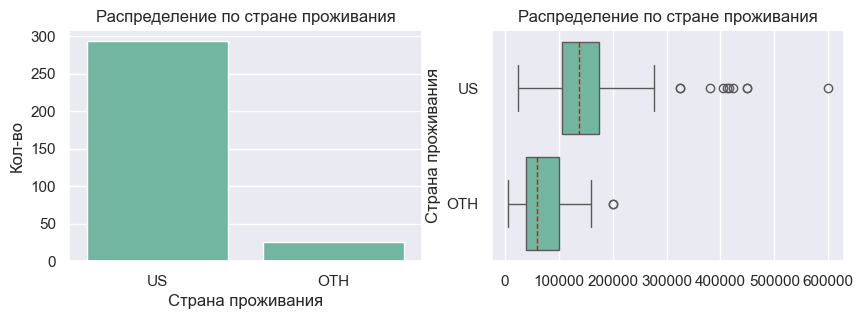

In [200]:
fig, axes = plt.subplots(1,2, figsize=(10, 3))
fig.subplots_adjust(hspace=0.5)
#Отбор американских компаний
data_US_company = data_popular[data_popular['company_location'] == 'US']

order_residence = data_US_company['employee_residence'].value_counts().index
sns.countplot(data_US_company, x='employee_residence', order=order_residence, ax=axes[0])
axes[0].set_title('Распределение по стране проживания')
axes[0].set(xlabel='Страна проживания', ylabel=x_name)
#plt.xticks(rotation=90);  # Повернуть подписи, если длинные


show_boxplot(data_US_company, 'employee_residence', 'Страна проживания', axes[1], False)
axes[1].set_title('Распределение по стране проживания');


Визуальный анализ данных указывает на различие в уровнях заработной платы американских команияй для американцев и работников из других страны. У американцев средний уровень заработной платы выше, чем у прочих работников. 

Формулируем статистическую гипотезу.

### 7. Как соотносятся заработные платы американских и иностранных работников при работе в американских компаниях

`Нулеввя гипотеза`: В американских компаниях, уровень заработной платы американцев ($\mu_\text{US}$) равен заработной плате работников из других стран ($\mu_\text{OTH}$).

$H_0: \mu_\text{US} = \mu_\text{OTH}$

`Альтернативная гипотеза`: В америаканских компаниях уровень заработной платы американцев ($\mu_\text{US}$) не равен уровню заработной платы работников из других стран ($\mu_\text{OTH}$)

$H_1: \mu_\text{US} \neq \mu_\text{OTH}$

In [201]:
#выбор данных и проверка на нормальность
data_US_company_US = data_US_company[data_US_company['employee_residence'] == 'US']['salary_in_usd']
data_US_company_OTH = data_US_company[data_US_company['employee_residence'] == 'OTH']['salary_in_usd']

#Проверка на нормальность
# проводим тест Шапиро-Уилка
print('Для Американских работников:')
result = stats.shapiro(data_US_company_US)
decision_normality(result[1])

print('Для иностранных работников:')
result = stats.shapiro(data_US_company_OTH)
decision_normality(result[1])

Для Американских работников:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для иностранных работников:
p-value = 0.031
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

In [202]:
print(Select_STest(p_typeData = 0,
                   p_cntGroup = 2,
                   p_addictGroup=False,
                   p_normData = False)
                   )

U-критерий Манна-Уитни: scipy.stats.mannwhitneyu()
Различен ли средний балл в конце первого полугодия у учеников двух разных классов?


In [203]:
# проводим тест
_, p = stats.mannwhitneyu(data_US_company_US, data_US_company_OTH, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: в американских компаниях, уровень заработной платы американцев отличается от уровня заработной платы иностранных работников

Следующим шагом выясним превышает уровень заработной платы американцев, в аиериканских компаниях, уровень заработной платы инстранных работников или нет

`Нулевая гипотеза`: Уровень заработной платы американцев ($\mu_\text{US}$) не превышает уровень заработной платы иностранных работников ($\mu_ \text{OTH}$)

$H_0: \mu_\text{US} \leq \mu_\text{OTH}$

`Альтернативная гипотеза`: Уровень заработной платы американцев ($\mu_\text{US}$) выше уровня заработной платы иностранных работников ($\mu_ \text{OTH}$) 

$H_1: \mu_\text{US} > \mu_\text{OTH}$

Используем тот же тест U-критерий Манна-Уитни, но с уточнением вида альтернативной гипотезы

In [204]:
# проводим тест
_, p = stats.mannwhitneyu(data_US_company_US, data_US_company_OTH, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


`Вывод: В американских компаниях, уровень заработной платы выше, чем у их иностранных коллег.`

### 8 Имеется ли зависимость между размером компании и объемом работ выполняемых удаленно

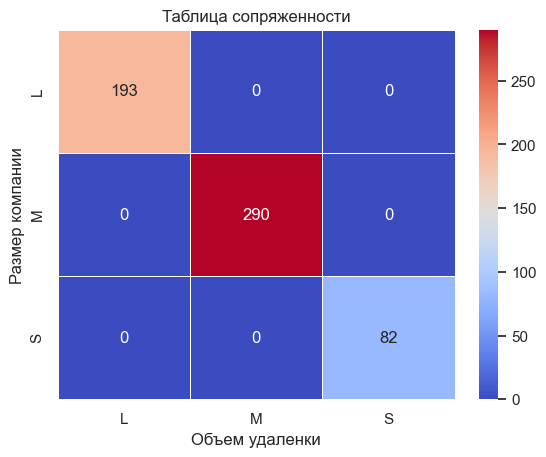

In [205]:
cross_tab = pd.crosstab(index=data['company_size'], columns=data['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Объем удаленки', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

`Нулевая нипотеза`: отсутствуе связь между размером компании и объемом работ на удаленке
`Альтернативная гипотеза`: имеется связь между размером компании и объемом работ на удаленке

**Выберем подходящий статистический тест**

* Какой тип у признаков ? — Категория.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.

In [206]:
print(Select_STest(p_typeData = 1,
                   p_cntGroup = 2,
                   p_addictGroup=False)
)

Критерий хи-квадрат (поиск связи): scipy.stats.chi2_contingency()
Есть ли связь между тарифом сотового оператора, и наличием детей у абонента?


In [207]:
# вычисляем таблицу сопряжённости
cross_tab = pd.crosstab(index=data['company_size'], columns=data['company_size'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)

decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


`Вывод: Имеется связь между размером компании и объемом работ выполняемых удаленно`